# Inspect the GP parameters


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az
import xarray as xr

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# %matplotlib notebook

In [3]:
# samples_az.to_netcdf('../DATA/swot_nadir_GP_itide_samples_v2.nc')
# priors_out_az.to_netcdf('../DATA/swot_nadir_GP_itide_priors_v2.nc')
# samples_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_samples_v2.nc')
# priors_out_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_priors_v2.nc')

# Tighter priors around d_t, l_t
samples_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_samples_v3.nc')
priors_out_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_priors_v3.nc')

# Trained with longer data
samples_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_samples_v4.nc')
priors_out_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_priors_v4.nc')

# Trained with longer data
samples_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_samples_jax_v2.nc')
priors_out_az = xr.open_dataset('../DATA/swot_nadir_GP_itide_priors_jax_v2.nc')

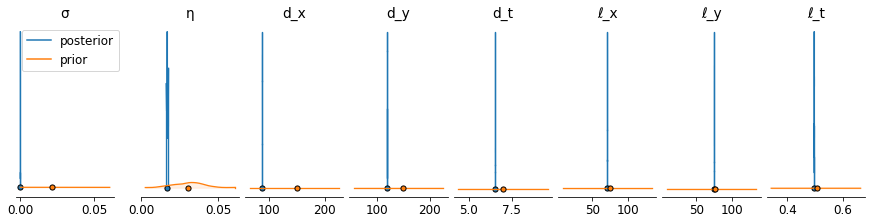

In [4]:
labels = ['σ','η','d_x','d_y','d_t','ℓ_x', 'ℓ_y','ℓ_t']
axs = az.plot_density(   [samples_az[labels],
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 8),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

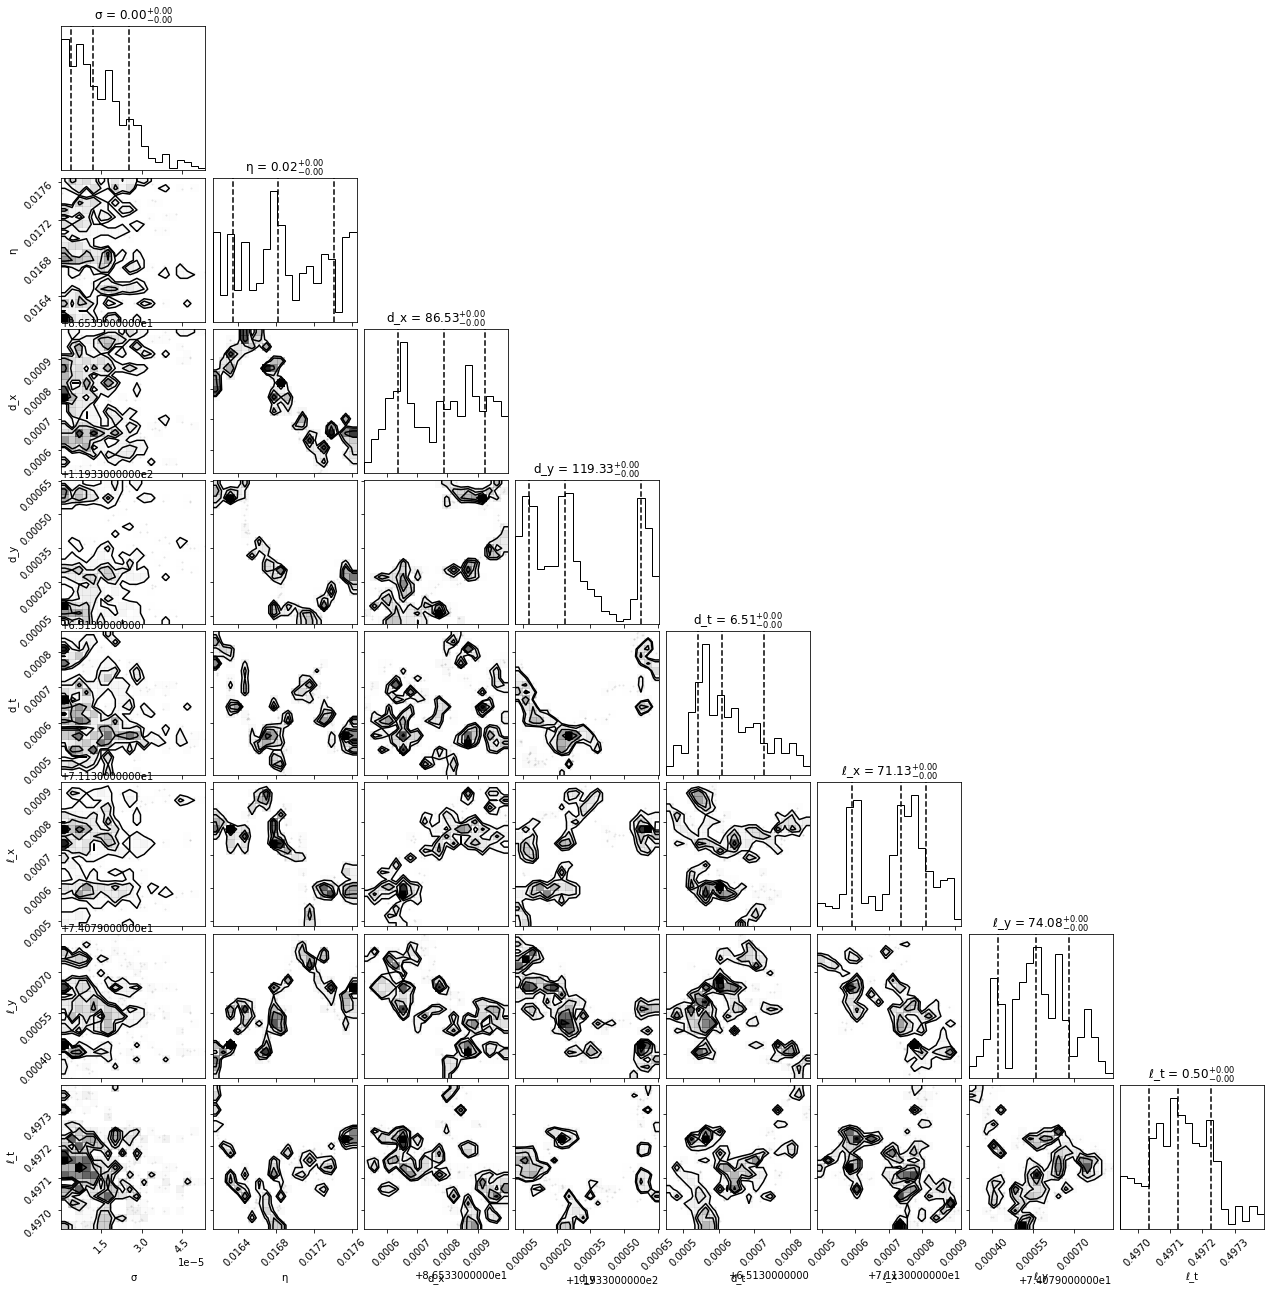

In [5]:
fig = corner.corner(samples_az,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])



In [46]:
# Generate a new prior with these parameters
covparams = [samples_az[ll].values.mean() for ll in labels[1:]]
noise_params = [samples_az[ll].values.mean() for ll in labels[0]][0]
noise_params, covparams

(1.4354033735605179e-05,
 [0.016884984097628338,
  86.53377707848938,
  119.33028102235961,
  6.5136275721880885,
  71.13071204545312,
  74.07956704757758,
  0.49713059342311205])

In [11]:
from sfoda.utils.myproj import MyProj

#swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023.nc')
# swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023_w_iwatlas.nc')
swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023_w_iwatlas.nc')

P = MyProj(None, utmzone=51, isnorth=False)
x,y = P.to_xy(swot.longitude.values, swot.latitude.values)

xpr, ypr = (x-x.mean())/1000, (y-y.mean())/1000

t = swot.time - swot.time[0]

tpr = t.values.astype(float)/1e9/86400.

XYT = np.array([xpr, ypr, tpr]).T
XYT.shape

(5457, 3)

In [12]:
from gptide import cov
from gptide import GPtideScipy
from scipy import stats
from gptide import stats as gpstats

def oscillate_1d(x, xpr, params, itfunc=cov.matern12):
    """
    1D Oscillatory kernel
    """
    eta, d, l = params
    
    return eta**2 * itfunc(x, xpr, d) * cov.cosine(x, xpr, l)

def K_itide_3d(x, xpr, params, **kwargs):
    eta, dx, dy, dt, lx, ly, lt = params

    # Build the covariance matrix
    C  = oscillate_1d(x[:,0,None], xpr.T[:,0,None].T, (1, dx, lx), **kwargs)
    C  *= oscillate_1d(x[:,1,None], xpr.T[:,1,None].T, (1, dy, ly), **kwargs)
    C  *= oscillate_1d(x[:,2,None], xpr.T[:,2,None].T, (1, dt, lt), **kwargs)
    C *= eta**2

    return C

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

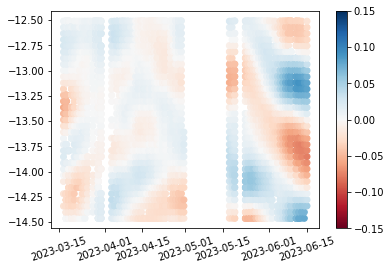

In [13]:
covfunc = K_itide_3d
cov_kwargs = {'itfunc':cov.matern32}
#####


GP = GPtideScipy(XYT, XYT.copy(), noise_params, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

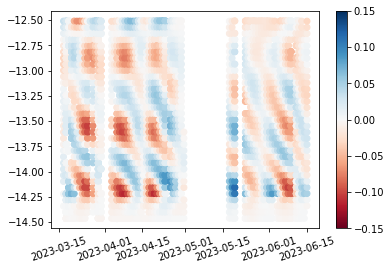

In [14]:
plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=swot.ssh_iwatlas.values, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# Make a prediction at one site

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


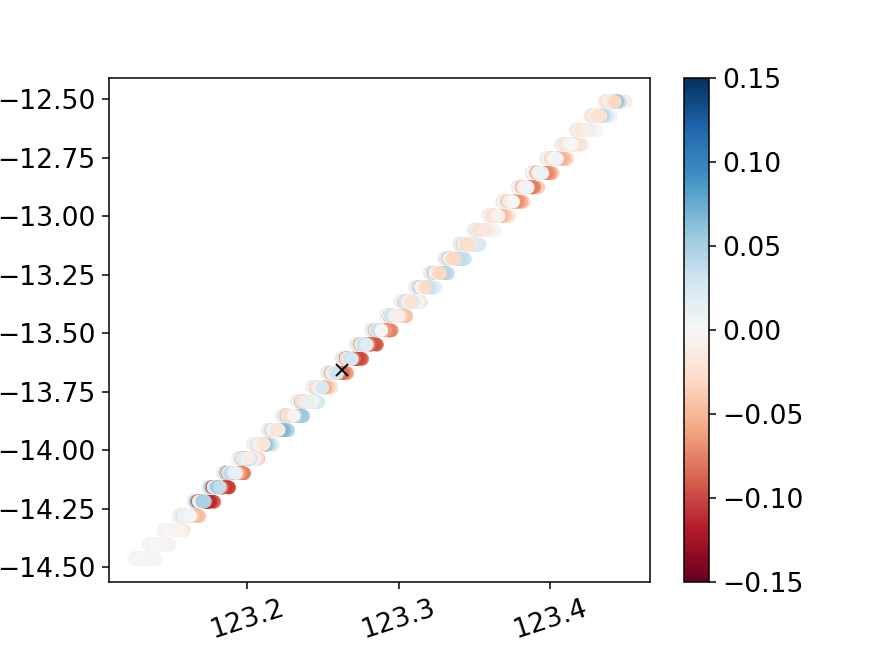

In [16]:
plt.figure()
plt.scatter(swot.longitude.values, swot.latitude.values, c=swot.ssh_iwatlas.values, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

lonsite, latsite = 123.263, -13.657
plt.plot(lonsite, latsite, 'kx')

<IPython.core.display.Javascript object>


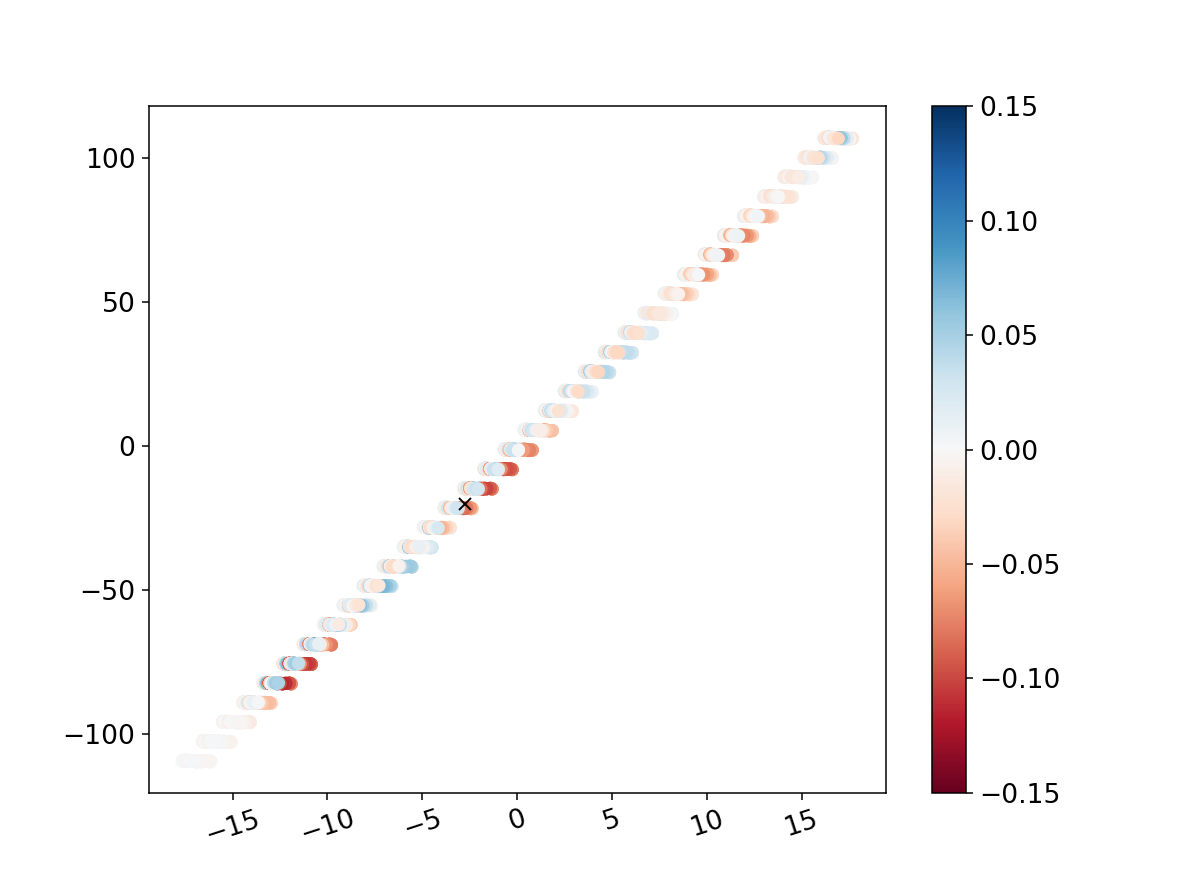

In [17]:

xsite,ysite = P.to_xy(lonsite, latsite)
xsitepr, ysitepr = (xsite-x.mean())/1000, (ysite-y.mean())/1000

plt.figure()
plt.scatter(xpr, ypr, c=swot.ssh_iwatlas.values, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

plt.plot(xsitepr, ysitepr, 'kx')

<IPython.core.display.Javascript object>


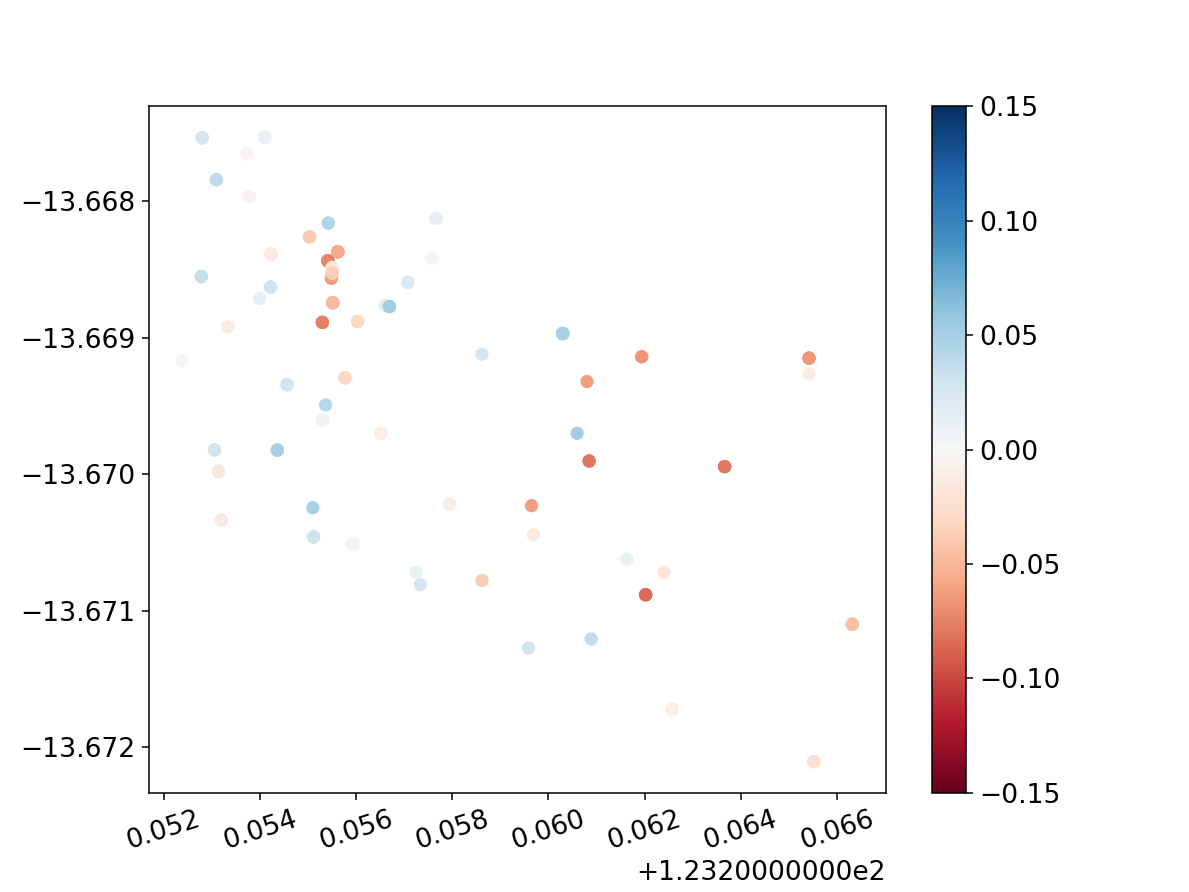

(array([123.25 , 123.255, 123.26 , 123.265, 123.27 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [18]:
dist = xr.DataArray(np.abs( (xsitepr-xpr) + 1J*(ysitepr-ypr)), dims=('time',) ,coords={
    'time':swot.time})

dist_cutoff = 2.
swotsite = swot.where(dist<dist_cutoff,  drop=True)

plt.figure()
plt.scatter(swotsite.longitude.values, swotsite.latitude.values, c=swotsite.ssh_iwatlas.values, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# plt.plot(xsitepr, ysitepr, 'kx')

In [26]:
# Create the coordinates
tlength = swot.time[-1]-swot.time[0]
dt = 3600
steps = (tlength.values.astype(float)*1e-9/dt).astype(int)

tout = np.arange(0,steps/24, 1/24)
timeout = np.array([swot.time.values[0] + np.timedelta64(int(tt*86400),'s') for tt in tout])

xout = xsitepr*np.ones_like(tout)
yout = ysitepr*np.ones_like(tout)

XYTout = np.array([xout, yout, tout]).T


In [27]:
%%time
GP = GPtideScipy(XYT, XYTout, noise_params, covfunc, covparams, cov_kwargs=cov_kwargs)

ssh_pred = GP(swot.ssh_iwatlas.values)
ssh_pred = GP.conditional(swot.ssh_iwatlas.values[:,None], samples=50)

CPU times: user 13.3 s, sys: 2.96 s, total: 16.3 s
Wall time: 10.4 s


<IPython.core.display.Javascript object>


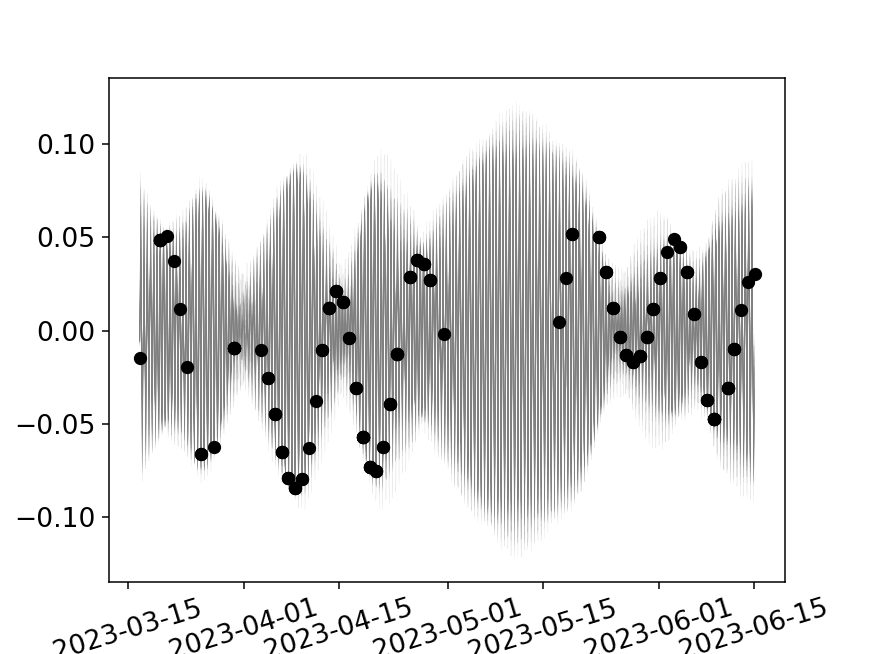

In [28]:
plt.figure()
plt.plot(timeout, ssh_pred,'0.5', lw=0.2, alpha=0.2)
plt.plot(swotsite.time, swotsite.ssh_iwatlas,'ko')

_ = plt.xticks(rotation=17)

In [29]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas import sshdriver
from iwatlas import harmonics

basedir = '/data-obs/jupyter-ubuntu/iwatlas'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

ssh = sshdriver.load_ssh_clim(atlasfile)
ssh

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, Np: 454016, Nmode: 4, Nk: 80, Nkw: 81, Nannual: 4, Nparams: 7, Ntide: 35)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79 79
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nc, numsides, Np, Nmode, Nkw, Nannual, Nparams, Ntide
Data variables: (12/15)
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    ...          ...
    N2_re       (Nannual, Nparams, Nc) float64 ...
    N2_im       (Nannual, Nparams, Nc) float64 ...
 

In [23]:
aa, Aa, Ba, frq = sshdriver.extract_hc_ssh(ssh, lonsite, latsite)
ssh_it = sshdriver.predict_scalar(timeout, aa, Aa, Ba, frq)


<IPython.core.display.Javascript object>


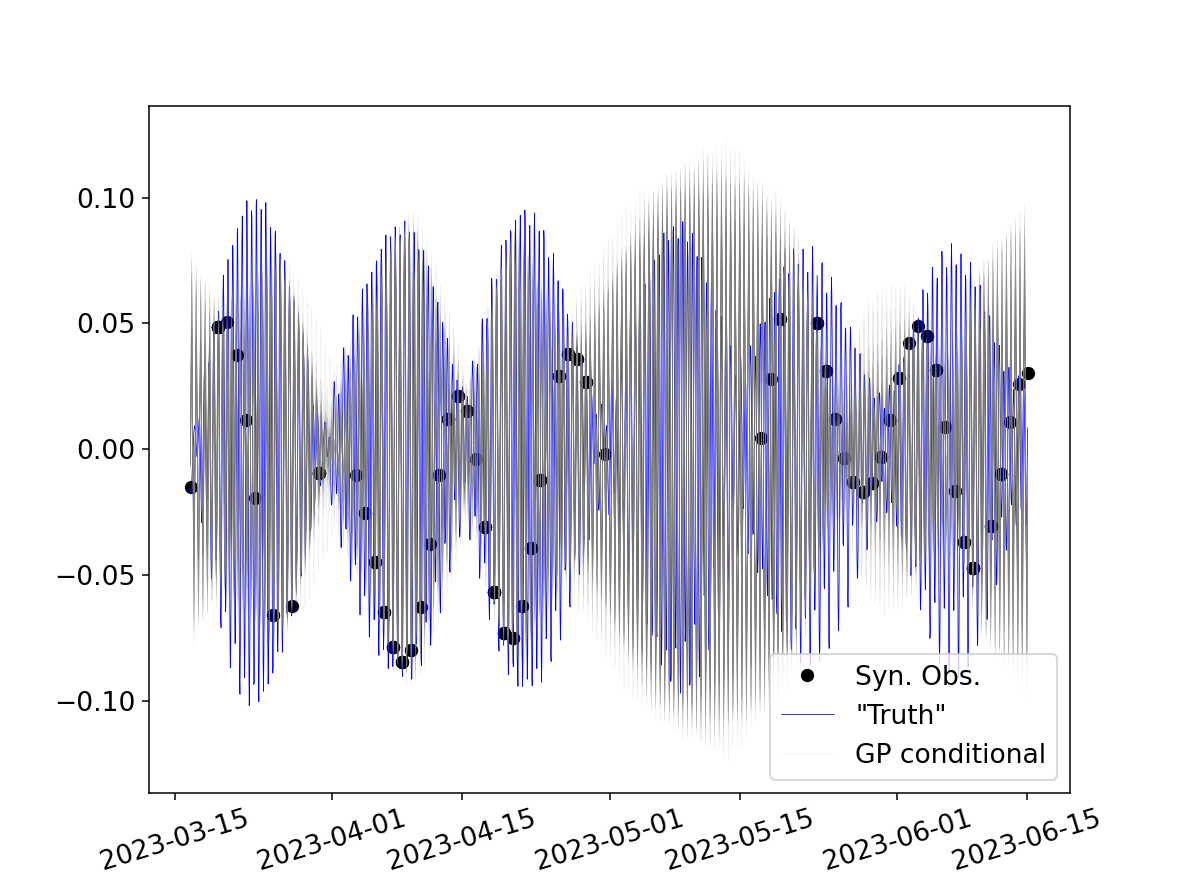

In [24]:
plt.figure()
plt.plot(swotsite.time, swotsite.ssh_iwatlas,'ko')
plt.plot(timeout, ssh_it,'b', lw=0.4)
plt.plot(timeout, ssh_pred,'0.5', lw=0.2,alpha=0.2)

_ = plt.xticks(rotation=17)

plt.legend(('Syn. Obs.','"Truth"','GP conditional',))

In [31]:
%%time

noise_params_guess = 0.00032295351839578
cov_params_guess = (0.0256231936970175,
  105.92650914776637,
  193.89539663890605,
  #5.,
  18.604015549831036, # l_t
  83.54675575580853,
  123.07375125696423,
  12.42/24)

GP = GPtideScipy(XYT, XYTout, noise_params_guess, covfunc, cov_params_guess, cov_kwargs=cov_kwargs)

ssh_pred = GP(swot.ssh_iwatlas.values)
ssh_pred = GP.conditional(swot.ssh_iwatlas.values[:,None], samples=50)

CPU times: user 13.3 s, sys: 2.89 s, total: 16.2 s
Wall time: 10.4 s


<IPython.core.display.Javascript object>


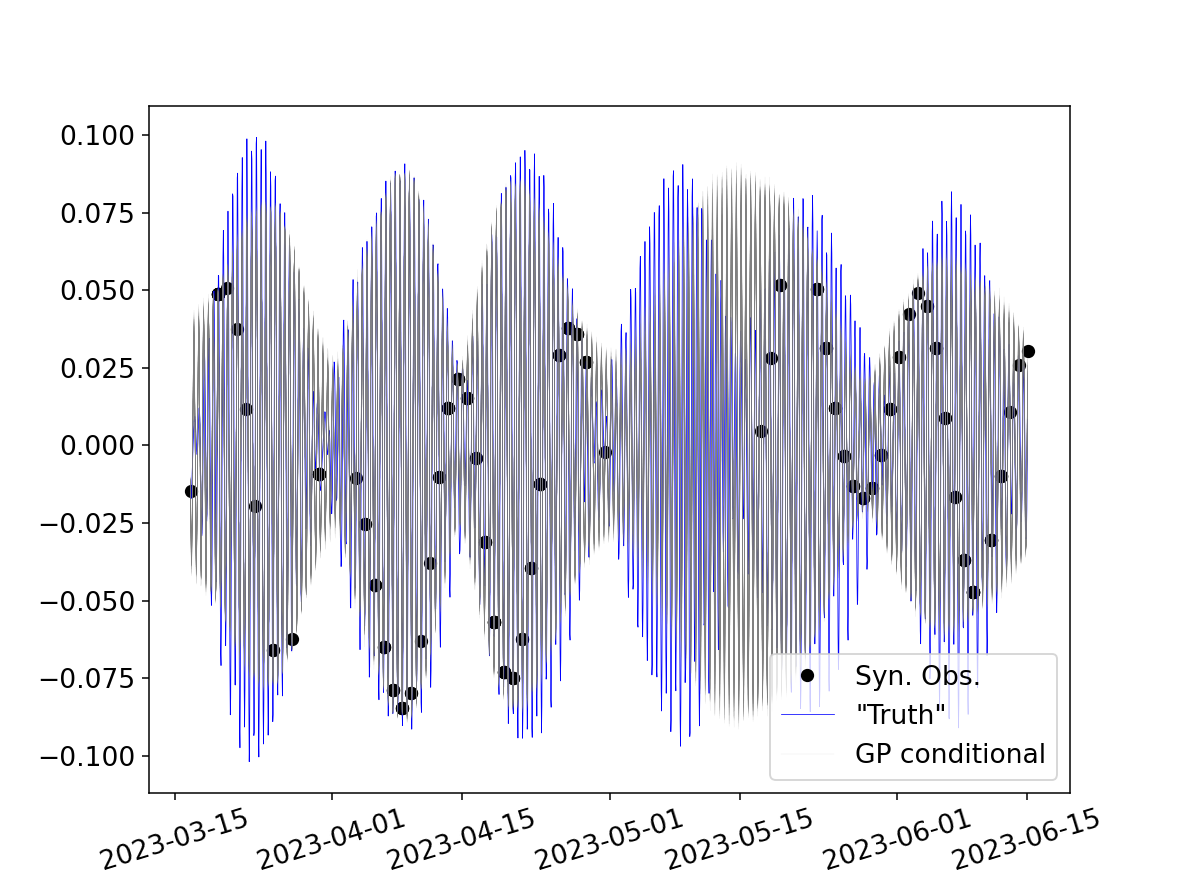

In [32]:
plt.figure()
plt.plot(swotsite.time, swotsite.ssh_iwatlas,'ko')
plt.plot(timeout, ssh_it,'b', lw=0.4)
plt.plot(timeout, ssh_pred,'0.5', lw=0.2,alpha=0.2)

_ = plt.xticks(rotation=17)

plt.legend(('Syn. Obs.','"Truth"','GP conditional',))

In [22]:
from gptide import GPtideJax

In [23]:
%%time
GP = GPtideJax(XYT, XYTout, noise_params_guess, covfunc, cov_params_guess, cov_kwargs=cov_kwargs)

# ssh_pred = GP(swot.ssh_iwatlas.values)
ssh_pred = GP.conditional(swot.ssh_iwatlas.values[:,None], samples=50)

CPU times: user 15.3 s, sys: 3.35 s, total: 18.6 s
Wall time: 11.8 s
